# Fixed-Size Chunking with Google Gemini
## Building a Document Q&A System

This notebook demonstrates how to implement fixed-size chunking to process large documents and create an intelligent Q&A system using Google's Gemini API.

### What You'll Learn:
- Understanding fixed-size chunking principles
- Implementing chunking strategies from scratch
- Integrating with Google Gemini API
- Building a practical document Q&A system
- Handling overlapping chunks and context preservation

### Project Overview:
We'll build a system that can:
1. Take a large document (research paper, book, article)
2. Split it into fixed-size chunks with overlap
3. Use Gemini to find relevant chunks for user questions
4. Generate comprehensive answers based on relevant content

## 1. Setup and Dependencies

In [1]:
# Install required packages
#!pip install google-generativeai tiktoken numpy scikit-learn requests beautifulsoup4 matplotlib python-dotenv

In [17]:
!pip install matplotlib

  Using cached matplotlib-3.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
  Using cached kiwisolver-1.4.8-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached fonttools-4.58.4-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (4.8 MB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached pillow-11.2.1-cp310-cp310-manylinux_2_28_x86_64.whl (4.6 MB)
  Using cached contourpy-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (325 kB)
You should consider upgrading via the '/home/mohdasimkhan/.pyenv/versions/3.10.2/envs/chunking/bin/python -m pip install --upgrade pip' command.


In [3]:
import google.generativeai as genai
import tiktoken
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re
import os
import time
from typing import List, Dict, Tuple
import requests
from bs4 import BeautifulSoup
import json

/home/mohdasimkhan/.pyenv/versions/3.10.2/envs/chunking/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
# Configure Gemini API
# Get your API key from https://makersuite.google.com/app/apikey
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY') # Replace with your actual API key or configure the key in .env
genai.configure(api_key=GEMINI_API_KEY)

# Initialize the model
model = genai.GenerativeModel('gemini-1.5-flash')

print("✅ Gemini API configured successfully!")

✅ Gemini API configured successfully!


## 2. Understanding Fixed-Size Chunking

Fixed-size chunking divides text into pieces of predetermined size. Let's explore the key concepts:

In [6]:
# Initialize tokenizer for accurate token counting
tokenizer = tiktoken.get_encoding("cl100k_base")  # GPT-4 tokenizer

def count_tokens(text: str) -> int:
    """Count tokens in text using tiktoken."""
    return len(tokenizer.encode(text))

# Demonstrate token counting
sample_text = """Artificial Intelligence (AI) has revolutionized numerous industries and continues to shape our world in unprecedented ways. From healthcare and finance to transportation and entertainment, AI technologies are transforming how we work, communicate, and live."""

print(f"Sample text: {sample_text}")
print(f"Character count: {len(sample_text)}")
print(f"Word count: {len(sample_text.split())}")
print(f"Token count: {count_tokens(sample_text)}")

Sample text: Artificial Intelligence (AI) has revolutionized numerous industries and continues to shape our world in unprecedented ways. From healthcare and finance to transportation and entertainment, AI technologies are transforming how we work, communicate, and live.
Character count: 257
Word count: 34
Token count: 43


## 3. Implementing Fixed-Size Chunking

In [7]:
class FixedSizeChunker:
    def __init__(self, chunk_size: int = 512, overlap: int = 50, method: str = 'token'):
        """
        Initialize the chunker.
        
        Args:
            chunk_size: Maximum size of each chunk
            overlap: Number of units to overlap between chunks
            method: 'token', 'character', or 'word'
        """
        self.chunk_size = chunk_size
        self.overlap = overlap
        self.method = method
        self.tokenizer = tiktoken.get_encoding("cl100k_base")
        
    def _get_size(self, text: str) -> int:
        """Get size of text based on method."""
        if self.method == 'token':
            return len(self.tokenizer.encode(text))
        elif self.method == 'character':
            return len(text)
        elif self.method == 'word':
            return len(text.split())
        else:
            raise ValueError("Method must be 'token', 'character', or 'word'")
    
    def _split_by_method(self, text: str) -> List[str]:
        """Split text into units based on method."""
        if self.method == 'token':
            tokens = self.tokenizer.encode(text)
            return [self.tokenizer.decode([token]) for token in tokens]
        elif self.method == 'character':
            return list(text)
        elif self.method == 'word':
            return text.split()
    
    def _join_units(self, units: List[str]) -> str:
        """Join units back into text."""
        if self.method == 'token':
            return ''.join(units)
        elif self.method == 'character':
            return ''.join(units)
        elif self.method == 'word':
            return ' '.join(units)
    
    def chunk_text(self, text: str) -> List[Dict]:
        """Chunk text into fixed-size pieces with overlap."""
        # Clean text
        text = re.sub(r'\s+', ' ', text.strip())
        
        chunks = []
        
        if self.method == 'token':
            # Token-based chunking (most accurate for AI models)
            tokens = self.tokenizer.encode(text)
            start = 0
            chunk_id = 0
            
            while start < len(tokens):
                end = min(start + self.chunk_size, len(tokens))
                chunk_tokens = tokens[start:end]
                chunk_text = self.tokenizer.decode(chunk_tokens)
                
                chunks.append({
                    'id': chunk_id,
                    'text': chunk_text,
                    'start_token': start,
                    'end_token': end,
                    'token_count': len(chunk_tokens),
                    'char_count': len(chunk_text)
                })
                
                start = end - self.overlap
                chunk_id += 1
                
                if end >= len(tokens):
                    break
        
        else:
            # Character or word-based chunking
            units = self._split_by_method(text)
            start = 0
            chunk_id = 0
            
            while start < len(units):
                end = min(start + self.chunk_size, len(units))
                chunk_units = units[start:end]
                chunk_text = self._join_units(chunk_units)
                
                chunks.append({
                    'id': chunk_id,
                    'text': chunk_text,
                    'start_pos': start,
                    'end_pos': end,
                    'unit_count': len(chunk_units),
                    'token_count': count_tokens(chunk_text),
                    'char_count': len(chunk_text)
                })
                
                start = end - self.overlap
                chunk_id += 1
                
                if end >= len(units):
                    break
        
        return chunks

print("✅ FixedSizeChunker class implemented!")

✅ FixedSizeChunker class implemented!


## 4. Testing the Chunker

In [8]:
# Sample document for testing
sample_document = """
Artificial Intelligence (AI) has become one of the most transformative technologies of the 21st century. 
From its humble beginnings in the 1950s with Alan Turing's famous test, AI has evolved into a sophisticated 
field encompassing machine learning, deep learning, natural language processing, and computer vision.

Machine learning, a subset of AI, enables computers to learn and improve from experience without being 
explicitly programmed. This technology powers recommendation systems, fraud detection, and predictive 
analytics across various industries. Deep learning, inspired by the human brain's neural networks, 
has revolutionized image recognition, speech processing, and game playing.

Natural Language Processing (NLP) allows machines to understand, interpret, and generate human language. 
This technology enables chatbots, language translation, sentiment analysis, and text summarization. 
Recent advances in large language models like GPT and BERT have dramatically improved NLP capabilities.

Computer vision enables machines to interpret and understand visual information from the world. 
Applications include autonomous vehicles, medical imaging, facial recognition, and quality control 
in manufacturing. The combination of these AI technologies is creating unprecedented opportunities 
and challenges across all sectors of society.

As AI continues to advance, ethical considerations become increasingly important. Issues such as bias, 
privacy, job displacement, and the need for transparent and explainable AI systems are at the forefront 
of current discussions. The future of AI promises even more exciting developments, including artificial 
general intelligence and quantum machine learning.
"""

# Test different chunking methods
chunkers = {
    'Token-based (512 tokens, 50 overlap)': FixedSizeChunker(chunk_size=512, overlap=50, method='token'),
    'Word-based (100 words, 10 overlap)': FixedSizeChunker(chunk_size=100, overlap=10, method='word'),
    'Character-based (500 chars, 50 overlap)': FixedSizeChunker(chunk_size=500, overlap=50, method='character')
}

for name, chunker in chunkers.items():
    print(f"\n=== {name} ===")
    chunks = chunker.chunk_text(sample_document)
    print(f"Number of chunks: {len(chunks)}")
    
    for i, chunk in enumerate(chunks[:2]):  # Show first 2 chunks
        print(f"\nChunk {i+1}:")
        print(f"Text: {chunk['text'][:100]}...")
        print(f"Tokens: {chunk['token_count']}, Characters: {chunk['char_count']}")


=== Token-based (512 tokens, 50 overlap) ===
Number of chunks: 1

Chunk 1:
Text: Artificial Intelligence (AI) has become one of the most transformative technologies of the 21st cent...
Tokens: 286, Characters: 1704

=== Word-based (100 words, 10 overlap) ===
Number of chunks: 3

Chunk 1:
Text: Artificial Intelligence (AI) has become one of the most transformative technologies of the 21st cent...
Tokens: 132, Characters: 743

Chunk 2:
Text: processing, and game playing. Natural Language Processing (NLP) allows machines to understand, inter...
Tokens: 127, Characters: 781

=== Character-based (500 chars, 50 overlap) ===
Number of chunks: 4

Chunk 1:
Text: Artificial Intelligence (AI) has become one of the most transformative technologies of the 21st cent...
Tokens: 90, Characters: 500

Chunk 2:
Text: nology powers recommendation systems, fraud detection, and predictive analytics across various indus...
Tokens: 87, Characters: 500


## 5. Project: Document Q&A System

Now let's build our main project - a document Q&A system using fixed-size chunking and Gemini.

In [12]:
class DocumentQASystem:
    def __init__(self, chunk_size: int = 400, overlap: int = 50):
        self.chunker = FixedSizeChunker(chunk_size=chunk_size, overlap=overlap, method='token')
        self.model = genai.GenerativeModel('gemini-1.5-flash')
        self.chunks = []
        self.document_title = ""
        
    def load_document(self, text: str, title: str = "Document"):
        """Load and chunk a document."""
        self.document_title = title
        self.chunks = self.chunker.chunk_text(text)
        print(f"✅ Loaded '{title}' with {len(self.chunks)} chunks")
        
    def _find_relevant_chunks(self, question: str, max_chunks: int = 3) -> List[Dict]:
        """Find most relevant chunks for a question using Gemini."""
        if not self.chunks:
            return []
            
        # Create a prompt to score relevance
        scoring_prompt = f"""
        Question: {question}
        
        I will provide you with text chunks. For each chunk, rate its relevance to answering the question on a scale of 0-10 (10 being most relevant).
        Respond with just the number for each chunk.
        
        Chunks:
        """
        
        # Score chunks in batches to avoid token limits
        batch_size = 5
        chunk_scores = []
        
        for i in range(0, len(self.chunks), batch_size):
            batch = self.chunks[i:i+batch_size]
            batch_prompt = scoring_prompt
            
            for j, chunk in enumerate(batch):
                batch_prompt += f"\n\nChunk {j+1}: {chunk['text']}"
            
            try:
                response = self.model.generate_content(batch_prompt)
                scores = re.findall(r'\d+', response.text)
                
                for j, score in enumerate(scores[:len(batch)]):
                    if i+j < len(self.chunks):
                        chunk_scores.append((int(score), i+j))
                        
                time.sleep(1)  # Rate limiting
                
            except Exception as e:
                print(f"Error scoring batch {i//batch_size + 1}: {e}")
                # Fallback: add chunks with medium scores
                for j in range(len(batch)):
                    if i+j < len(self.chunks):
                        chunk_scores.append((5, i+j))
        
        # Sort by score and return top chunks
        chunk_scores.sort(reverse=True)
        top_indices = [idx for _, idx in chunk_scores[:max_chunks]]
        
        return [self.chunks[idx] for idx in top_indices]
    
    def answer_question(self, question: str) -> Dict:
        """Answer a question based on the document."""
        if not self.chunks:
            return {"error": "No document loaded"}
        
        print(f"🔍 Finding relevant chunks for: {question}")
        
        # Find relevant chunks
        relevant_chunks = self._find_relevant_chunks(question)
        
        if not relevant_chunks:
            return {"error": "No relevant content found"}
        
        # Combine relevant chunks
        context = "\n\n".join([chunk['text'] for chunk in relevant_chunks])
        
        # Generate answer
        answer_prompt = f"""
        Based on the following context from the document "{self.document_title}", please answer the question thoroughly and accurately.
        
        Context:
        {context}
        
        Question: {question}
        
        Answer: Provide a comprehensive answer based solely on the information in the context. If the context doesn't contain enough information to fully answer the question, mention this limitation.
        """
        
        try:
            response = self.model.generate_content(answer_prompt)
            
            return {
                "question": question,
                "answer": response.text,
                "relevant_chunks": len(relevant_chunks),
                "chunk_ids": [chunk['id'] for chunk in relevant_chunks],
                "context_tokens": sum(chunk['token_count'] for chunk in relevant_chunks)
            }
            
        except Exception as e:
            return {"error": f"Failed to generate answer: {e}"}

print("✅ DocumentQASystem class implemented!")

✅ DocumentQASystem class implemented!


## 6. Loading Sample Data

Let's load a larger document to test our system. We'll use a comprehensive AI research article.

In [13]:
# Extended AI research document
ai_research_document = """
The Evolution and Future of Artificial Intelligence: A Comprehensive Analysis

Abstract:
Artificial Intelligence (AI) has undergone remarkable transformation since its inception in the 1950s. This paper examines the historical development, current state, and future prospects of AI technologies, with particular focus on machine learning, deep learning, and their applications across various domains.

1. Introduction

Artificial Intelligence represents one of humanity's most ambitious technological pursuits. The field emerged from the confluence of mathematics, computer science, psychology, and philosophy, with the goal of creating machines capable of intelligent behavior. The term "artificial intelligence" was first coined by John McCarthy in 1956 at the Dartmouth Conference, marking the official birth of AI as a academic discipline.

The journey of AI has been characterized by periods of great optimism followed by "AI winters" of reduced funding and interest. However, the last two decades have witnessed unprecedented growth in AI capabilities, driven primarily by advances in computational power, data availability, and algorithmic innovations.

2. Historical Development

2.1 Early Foundations (1950s-1960s)
The foundations of AI were laid by pioneers like Alan Turing, who proposed the famous Turing Test as a criterion for machine intelligence. Early AI programs like the Logic Theorist and General Problem Solver demonstrated that machines could perform tasks requiring logical reasoning.

2.2 The First AI Winter (1970s-1980s)
Despite initial enthusiasm, AI faced significant challenges in the 1970s. The limitations of early approaches became apparent, leading to reduced funding and a period known as the "AI winter." However, this period also saw the development of expert systems, which achieved commercial success in specific domains.

2.3 Renaissance and Machine Learning (1990s-2000s)
The 1990s marked a renaissance in AI research, driven by new approaches to machine learning. Statistical methods and probabilistic reasoning gained prominence, leading to breakthrough applications in areas like speech recognition and computer vision.

3. Modern AI and Deep Learning

3.1 The Deep Learning Revolution
The 2010s witnessed the deep learning revolution, fundamentally changing the landscape of AI. Convolutional Neural Networks (CNNs) achieved superhuman performance in image recognition tasks, while Recurrent Neural Networks (RNNs) and later Transformers revolutionized natural language processing.

3.2 Key Breakthrough Technologies

Convolutional Neural Networks (CNNs): Inspired by the visual cortex, CNNs excel at processing grid-like data such as images. The success of AlexNet in 2012 ImageNet competition marked the beginning of the deep learning era in computer vision.

Recurrent Neural Networks (RNNs): Designed to handle sequential data, RNNs and their variants like LSTM and GRU networks became crucial for tasks involving time series, speech, and language processing.

Transformer Architecture: Introduced in 2017, the Transformer architecture revolutionized NLP through its attention mechanism, enabling the development of large language models like BERT, GPT, and their successors.

Generative Adversarial Networks (GANs): GANs enable the generation of realistic synthetic data, finding applications in image synthesis, data augmentation, and creative AI applications.

4. Current Applications and Impact

4.1 Healthcare and Medicine
AI has shown remarkable promise in healthcare, with applications ranging from medical imaging and diagnosis to drug discovery and personalized treatment. Deep learning models can detect diseases in medical images with accuracy matching or exceeding human specialists.

4.2 Autonomous Systems
Self-driving cars represent one of the most visible applications of AI technology. These systems combine computer vision, sensor fusion, and decision-making algorithms to navigate complex environments safely.

4.3 Natural Language Processing
Large language models have achieved unprecedented capabilities in understanding and generating human language. These models power virtual assistants, translation services, and content generation tools.

4.4 Financial Services
AI algorithms are widely used in finance for fraud detection, algorithmic trading, risk assessment, and customer service automation. Machine learning models can process vast amounts of financial data to identify patterns and make predictions.

5. Challenges and Limitations

5.1 Ethical Considerations
As AI systems become more powerful and widespread, ethical concerns have gained prominence. Issues include algorithmic bias, privacy concerns, job displacement, and the potential for misuse of AI technology.

5.2 Technical Limitations
Despite significant progress, current AI systems face limitations including lack of common sense reasoning, brittleness to adversarial examples, and inability to generalize beyond training data.

5.3 Data and Computational Requirements
Modern AI systems require enormous amounts of data and computational resources, raising concerns about accessibility and environmental impact.

6. Future Directions

6.1 Artificial General Intelligence (AGI)
The ultimate goal of AI research remains the development of Artificial General Intelligence - systems that can match or exceed human cognitive abilities across all domains.

6.2 Explainable AI
As AI systems are deployed in critical applications, the need for explainable and interpretable AI becomes crucial. Research focuses on developing methods to make AI decision-making transparent and understandable.

6.3 Quantum Machine Learning
The intersection of quantum computing and machine learning holds promise for solving certain computational problems exponentially faster than classical computers.

7. Conclusion

Artificial Intelligence has evolved from a theoretical concept to a transformative technology that impacts nearly every aspect of modern life. While significant challenges remain, the continued advancement of AI promises to bring about revolutionary changes in how we work, live, and understand intelligence itself.

The future of AI will likely be characterized by more sophisticated systems that can reason, learn, and adapt in ways that closely mimic human intelligence. However, realizing this potential will require careful consideration of ethical implications and continued research into the fundamental nature of intelligence and learning.

As we stand on the brink of potentially achieving artificial general intelligence, it is crucial that we approach this development with wisdom, ensuring that AI remains a tool for human flourishing rather than a source of harm or inequality.
"""

# Initialize the Q&A system
qa_system = DocumentQASystem(chunk_size=400, overlap=50)
qa_system.load_document(ai_research_document, "AI Research Paper")

print(f"Document loaded with {len(qa_system.chunks)} chunks")
print(f"Total tokens: {sum(chunk['token_count'] for chunk in qa_system.chunks)}")

✅ Loaded 'AI Research Paper' with 4 chunks
Document loaded with 4 chunks
Total tokens: 1348


## 7. Testing the Q&A System

In [14]:
# Test questions about the document
test_questions = [
    "What is the Transformer architecture and why is it important?",
    "What are the main challenges facing AI development today?",
    "How has AI evolved since the 1950s?",
    "What are the applications of AI in healthcare?",
    "What is Artificial General Intelligence?"
]

print("🤖 Testing Document Q&A System\n")

for i, question in enumerate(test_questions[:2], 1):  # Test first 2 questions
    print(f"\n{'='*60}")
    print(f"Question {i}: {question}")
    print(f"{'='*60}")
    
    result = qa_system.answer_question(question)
    
    if "error" in result:
        print(f"❌ Error: {result['error']}")
    else:
        print(f"\n📝 Answer:")
        print(result["answer"])
        print(f"\n📊 Stats:")
        print(f"  - Relevant chunks used: {result['relevant_chunks']}")
        print(f"  - Chunk IDs: {result['chunk_ids']}")
        print(f"  - Context tokens: {result['context_tokens']}")
    
    print("\n" + "-"*60)

🤖 Testing Document Q&A System


Question 1: What is the Transformer architecture and why is it important?
🔍 Finding relevant chunks for: What is the Transformer architecture and why is it important?

📝 Answer:
The Transformer architecture, introduced in 2017, revolutionized Natural Language Processing (NLP) through its attention mechanism.  This mechanism enabled the development of large language models like BERT, GPT, and their successors.  The provided text does not elaborate further on the specifics of the attention mechanism or how it leads to improved NLP capabilities.


📊 Stats:
  - Relevant chunks used: 3
  - Chunk IDs: [1, 0, 2]
  - Context tokens: 1200

------------------------------------------------------------

Question 2: What are the main challenges facing AI development today?
🔍 Finding relevant chunks for: What are the main challenges facing AI development today?

📝 Answer:
Based on the provided text, the main challenges facing AI development today are:

* **Ethical Con

## 8. Advanced Chunking Techniques

In [15]:
class AdvancedChunker(FixedSizeChunker):
    """Advanced chunker with additional features."""
    
    def __init__(self, chunk_size: int = 512, overlap: int = 50, 
                 preserve_sentences: bool = True, min_chunk_size: int = 100):
        super().__init__(chunk_size, overlap, 'token')
        self.preserve_sentences = preserve_sentences
        self.min_chunk_size = min_chunk_size
    
    def _split_sentences(self, text: str) -> List[str]:
        """Split text into sentences."""
        # Simple sentence splitting (can be improved with spaCy or NLTK)
        sentences = re.split(r'(?<=[.!?])\s+', text)
        return [s.strip() for s in sentences if s.strip()]
    
    def chunk_text_advanced(self, text: str) -> List[Dict]:
        """Advanced chunking with sentence preservation."""
        if not self.preserve_sentences:
            return self.chunk_text(text)
        
        sentences = self._split_sentences(text)
        chunks = []
        current_chunk = ""
        current_sentences = []
        chunk_id = 0
        
        for sentence in sentences:
            # Check if adding this sentence would exceed chunk size
            test_chunk = current_chunk + " " + sentence if current_chunk else sentence
            
            if count_tokens(test_chunk) <= self.chunk_size:
                current_chunk = test_chunk
                current_sentences.append(sentence)
            else:
                # Save current chunk if it meets minimum size
                if current_chunk and count_tokens(current_chunk) >= self.min_chunk_size:
                    chunks.append({
                        'id': chunk_id,
                        'text': current_chunk,
                        'sentences': current_sentences.copy(),
                        'token_count': count_tokens(current_chunk),
                        'char_count': len(current_chunk)
                    })
                    chunk_id += 1
                
                # Start new chunk
                # Add overlap from previous chunk if specified
                if self.overlap > 0 and current_sentences:
                    overlap_sentences = current_sentences[-min(self.overlap, len(current_sentences)):]
                    current_chunk = " ".join(overlap_sentences + [sentence])
                    current_sentences = overlap_sentences + [sentence]
                else:
                    current_chunk = sentence
                    current_sentences = [sentence]
        
        # Add final chunk
        if current_chunk and count_tokens(current_chunk) >= self.min_chunk_size:
            chunks.append({
                'id': chunk_id,
                'text': current_chunk,
                'sentences': current_sentences,
                'token_count': count_tokens(current_chunk),
                'char_count': len(current_chunk)
            })
        
        return chunks

# Test advanced chunker
advanced_chunker = AdvancedChunker(chunk_size=300, overlap=2, preserve_sentences=True)
advanced_chunks = advanced_chunker.chunk_text_advanced(sample_document)

print(f"\n🔧 Advanced Chunking Results:")
print(f"Number of chunks: {len(advanced_chunks)}")

for i, chunk in enumerate(advanced_chunks[:2]):
    print(f"\nChunk {i+1}:")
    print(f"Sentences: {len(chunk['sentences'])}")
    print(f"Tokens: {chunk['token_count']}")
    print(f"Text preview: {chunk['text'][:150]}...")


🔧 Advanced Chunking Results:
Number of chunks: 1

Chunk 1:
Sentences: 14
Tokens: 296
Text preview: Artificial Intelligence (AI) has become one of the most transformative technologies of the 21st century. From its humble beginnings in the 1950s with ...


## 9. Performance Analysis and Visualization

📊 Analyzing chunk performance...


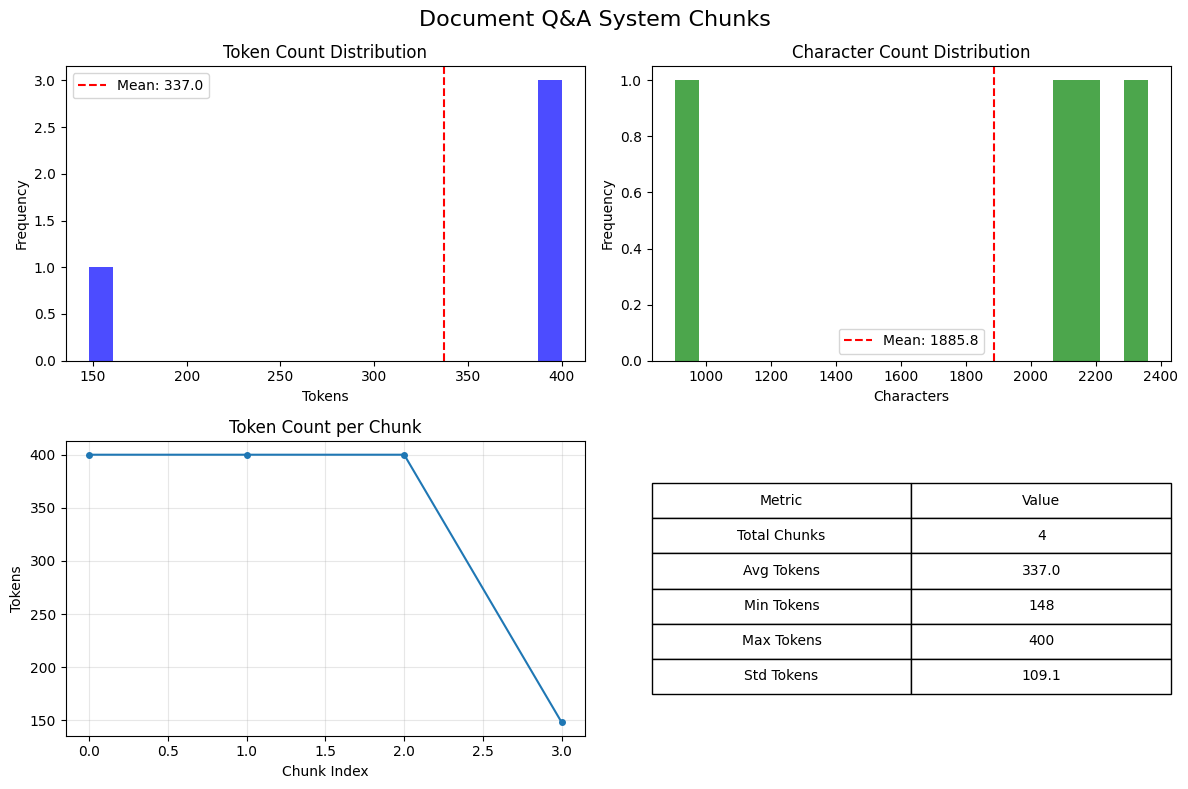

In [18]:
import matplotlib.pyplot as plt

def analyze_chunks(chunks: List[Dict], title: str = "Chunk Analysis"):
    """Analyze and visualize chunk statistics."""
    token_counts = [chunk['token_count'] for chunk in chunks]
    char_counts = [chunk['char_count'] for chunk in chunks]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(title, fontsize=16)
    
    # Token count distribution
    ax1.hist(token_counts, bins=20, alpha=0.7, color='blue')
    ax1.set_title('Token Count Distribution')
    ax1.set_xlabel('Tokens')
    ax1.set_ylabel('Frequency')
    ax1.axvline(np.mean(token_counts), color='red', linestyle='--', label=f'Mean: {np.mean(token_counts):.1f}')
    ax1.legend()
    
    # Character count distribution
    ax2.hist(char_counts, bins=20, alpha=0.7, color='green')
    ax2.set_title('Character Count Distribution')
    ax2.set_xlabel('Characters')
    ax2.set_ylabel('Frequency')
    ax2.axvline(np.mean(char_counts), color='red', linestyle='--', label=f'Mean: {np.mean(char_counts):.1f}')
    ax2.legend()
    
    # Token count over chunks
    ax3.plot(range(len(chunks)), token_counts, marker='o', markersize=4)
    ax3.set_title('Token Count per Chunk')
    ax3.set_xlabel('Chunk Index')
    ax3.set_ylabel('Tokens')
    ax3.grid(True, alpha=0.3)
    
    # Summary statistics table
    stats = {
        'Metric': ['Total Chunks', 'Avg Tokens', 'Min Tokens', 'Max Tokens', 'Std Tokens'],
        'Value': [len(chunks), f"{np.mean(token_counts):.1f}", 
                 f"{min(token_counts)}", f"{max(token_counts)}", f"{np.std(token_counts):.1f}"]
    }
    
    ax4.axis('tight')
    ax4.axis('off')
    table = ax4.table(cellText=list(zip(stats['Metric'], stats['Value'])),
                     colLabels=['Metric', 'Value'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'total_chunks': len(chunks),
        'avg_tokens': np.mean(token_counts),
        'min_tokens': min(token_counts),
        'max_tokens': max(token_counts),
        'std_tokens': np.std(token_counts)
    }

# Analyze our chunking results
print("📊 Analyzing chunk performance...")
stats = analyze_chunks(qa_system.chunks, "Document Q&A System Chunks")

## 10. Interactive Q&A Demo

In [ ]:
def interactive_qa_demo():
    """Interactive demo of the Q&A system."""
    print("🎯 Interactive Q&A Demo")
    print("Ask questions about the AI research document!")
    print("Type 'quit' to exit\n")
    
    while True:
        question = input("❓ Your question: ").strip()
        
        if question.lower() in ['quit', 'exit', 'q']:
            print("👋 Thank you for using the Q&A system!")
            break
        
        if not question:
            continue
        
        print(f"\n🤔 Processing: {question}")
        result = qa_system.answer_question(question)
        
        if "error" in result:
            print(f"❌ Error: {result['error']}")
        else:
            print(f"\n💡 Answer:")
            print(result["answer"])
            print(f"\n📈 Used {result['relevant_chunks']} chunks ({result['context_tokens']} tokens)")
        
        print("\n" + "-"*60 + "\n")

# Uncomment the next line to run interactive demo
# interactive_qa_demo()

## 11. Best Practices and Tips

In [ ]:
def chunking_best_practices():
    """Display best practices for fixed-size chunking."""
    
    practices = {
        "🎯 Chunk Size Selection": [
            "• 256-512 tokens for most general applications",
            "• 128-256 tokens for precise retrieval",
            "• 512-1024 tokens for comprehensive context",
            "• Consider your model's context window"
        ],
        
        "🔄 Overlap Strategy": [
            "• 10-20% overlap prevents information loss",
            "• Higher overlap for critical applications",
            "• Consider computational cost vs. quality",
            "• Test with your specific use case"
        ],
        
        "📝 Content Preprocessing": [
            "• Clean and normalize text before chunking",
            "• Preserve important formatting markers",
            "• Handle special characters appropriately",
            "• Consider document structure (headers, lists)"
        ],
        
        "⚡ Performance Optimization": [
            "• Use token-based chunking for accuracy",
            "• Batch process multiple documents",
            "• Cache chunks when possible",
            "• Monitor memory usage with large documents"
        ],
        
        "🔍 Quality Assurance": [
            "• Test chunk boundaries for coherence",
            "• Validate retrieval quality",
            "• Monitor for information loss",
            "• Adjust parameters based on results"
        ]
    }
    
    print("📚 Fixed-Size Chunking Best Practices\n")
    
    for category, tips in practices.items():
        print(f"{category}")
        for tip in tips:
            print(f"  {tip}")
        print()

chunking_best_practices()

## 12. Conclusion

In this notebook, we've explored fixed-size chunking techniques and built a practical document Q&A system using Google Gemini. Key takeaways:

### What We've Learned:
1. **Fixed-size chunking** is simple but effective for processing large documents
2. **Token-based chunking** provides the most accurate results for AI models
3. **Overlap strategies** help preserve context across chunk boundaries
4. **Gemini integration** enables sophisticated document understanding
5. **Performance analysis** helps optimize chunking parameters

### Next Steps:
- Experiment with different chunk sizes and overlap ratios
- Try semantic chunking for better context preservation
- Implement vector similarity search for improved retrieval
- Add support for multiple document types (PDF, HTML, etc.)
- Deploy the system as a web application

### Further Exploration:
- Hierarchical chunking for multi-level document structure
- Adaptive chunking based on content density
- Chunk summarization for better retrieval
- Integration with vector databases like Pinecone or Weaviate

Happy chunking! 🚀